# Permodelan Cluster 1

Import segala pustaka (library) yang digunakan


In [62]:
import tensorflow as tf #untuk mempermudah pembuatan deep learning
import pandas as pd #mempermudah pembacaan data dengan ukuran besar (big data) dari data penjualan
import numpy as np #mempermudah pengolahan data dari library sebelumnya
import matplotlib.pyplot as plt #untuk mempermudah visualisasi
from sklearn.preprocessing import MinMaxScaler #untuk menskala data sehingga mudah dibaca dan diproses deep learning

## Pembacaan Data

Baca dataset train

In [63]:
data=pd.read_excel('../dataset_new.xlsx',sheet_name='train')
data

,KodeBarang,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,cluster
0,04121,7,9,6,9,40,0,3,0,7,...,67,77,11,57,43,50,37,21,136,0
1,18031,230,227,279,153,190,256,267,305,238,...,336,153,103,221,360,280,240,120,548,1
2,04161,102,50,45,41,71,11,52,14,66,...,21,20,7,33,21,28,30,10,18,0
3,04162,272,155,214,226,268,110,204,253,193,...,102,118,120,211,292,105,108,101,117,1
4,04163,28,28,29,52,44,21,47,15,24,...,18,23,22,16,22,31,36,17,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,04157,55,64,44,61,30,1,24,37,67,...,20,10,300,34,7,7,6,4,21,0
102,18104,46,295,83,112,70,40,18,140,97,...,47,54,27,15,57,132,66,34,146,0
103,18106,200,204,0,2,10,7,0,27,74,...,15,136,15,15,14,131,84,12,14,0
104,18092,297,418,329,70,498,59,298,376,259,...,450,498,254,260,336,493,438,408,322,1


Baca dataset test

In [64]:
data_test=pd.read_excel('../dataset_new.xlsx',sheet_name='test')
data_test

,KodeBarang,bulan 1,bulan 2,bulan 3,bulan 4,bulan 5,bulan 6
0,04121,5,12,8,14,40,40
1,18031,573,340,441,270,488,240
2,04161,27,5,26,34,40,56
3,04162,162,82,72,98,126,120
4,04163,23,20,9,5,22,6
...,...,...,...,...,...,...,...
101,04157,138,14,12,21,25,10
102,18104,60,103,39,87,276,40
103,18106,16,7,65,24,13,27
104,18092,721,184,150,488,648,149


Hilangkan judul kolom agar tidak terbaca di deep learning

In [65]:
# data_test.drop(['bulan 4','bulan 5','bulan 6'],axis=1,inplace=True)


Pastikan cluster pada dataset sudah berupa angka

In [66]:
data_test['cluster']=data['cluster'].astype(int)
data_test

,KodeBarang,bulan 1,bulan 2,bulan 3,bulan 4,bulan 5,bulan 6,cluster
0,04121,5,12,8,14,40,40,0
1,18031,573,340,441,270,488,240,1
2,04161,27,5,26,34,40,56,0
3,04162,162,82,72,98,126,120,1
4,04163,23,20,9,5,22,6,0
...,...,...,...,...,...,...,...,...
101,04157,138,14,12,21,25,10,0
102,18104,60,103,39,87,276,40,0
103,18106,16,7,65,24,13,27,0
104,18092,721,184,150,488,648,149,1


Make sure ada berapa cluster?

In [67]:
len(data['cluster'].unique())

4

Ambil jumlah produk dalam cluster ada berapa

In [68]:
#now lets take clusters
c0 = data.query("cluster == 0")
print("Jumlah Produk:")
print(c0['KodeBarang'].size)
c1 = data.query("cluster == 1")
print("Jumlah Produk:")
print(c1['KodeBarang'].size)
c2 = data.query("cluster == 2")
print("Jumlah Produk:")
print(c2['KodeBarang'].size)
c3 = data.query("cluster == 3")
print("Jumlah Produk:")
print(c3['KodeBarang'].size)

Jumlah Produk:
70
Jumlah Produk:
31
Jumlah Produk:
4
Jumlah Produk:
1


Sama cuman data test, make sure keduanya sama

In [69]:
c0_t = data_test.query("cluster == 0")
print("Jumlah Produk:")
print(c0['KodeBarang'].size)
c1_t = data_test.query("cluster == 1")
print("Jumlah Produk:")
print(c1['KodeBarang'].size)
c2_t = data_test.query("cluster == 2")
print("Jumlah Produk:")
print(c2['KodeBarang'].size)
c3_t = data_test.query("cluster == 3")
print("Jumlah Produk:")
print(c3['KodeBarang'].size)

Jumlah Produk:
70
Jumlah Produk:
31
Jumlah Produk:
4
Jumlah Produk:
1


## Pembuatan model cluster 1

Buat fungsi bikin `windowed dataset` jadi si data di couple in sama waktu (timeframe)

In [70]:
#oke ada ternyata yang cuman sendirian (1 product di cluster tersebut), kita beresin dia dulu, the easiest, dan biar keliatan kita
#ngapain aja di time series ini
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
# ini fungsinya buat nge ubah dataset jadi windowed

ubah tipe data dari kode barang menjadi nilai angka

In [71]:
col = c1.KodeBarang.values

In [72]:
#next kita ubah bentuk data nya dari yang tadinya kesamping jadi ke bawah, tapi pertama mau aku drop dulu cluster sama kode produknya
c1=c1.drop(columns=['KodeBarang','cluster'])
c1_t=c1_t.drop(columns=['KodeBarang','cluster'])

Plot per produk cluster 1

<AxesSubplot:>

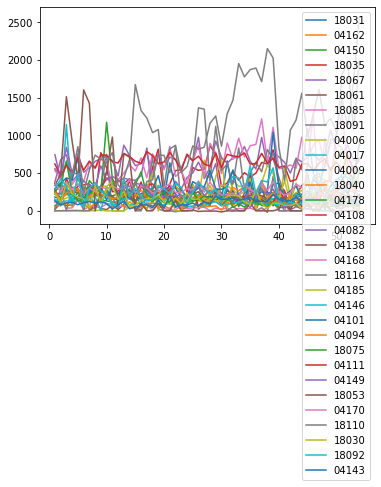

In [73]:
c1.set_index(col,inplace=True)
c1.T.plot()

In [74]:
#Ambil satu sample dari cluster 1
# c1 = c1.sample()

In [75]:
# c1.T.plot()
#Kode 04146 hasilnya sangat bagus

In [76]:
#next, buat dia kayak mejeneng time series seperti biasanya, which is datanya ke bawah, tapi di average per tanggal 
new_c1=[]
time=[]
for idx,a in enumerate(c1):
    new_c1.append(c1[a].mean())
    time.append(idx)


In [77]:
#sama aja cuman data test
new_c1_t=[]
time_t=[]
i = 55
for idx,a in enumerate(c1_t):
    new_c1_t.append(c1_t[a].mean())
    time_t.append(i)
    i+=1

In [78]:
#normalisasi, karena gap nya ada yang sampe ribuan, biar lebih gampang tugas ann nya
series=new_c1
min = np.min(series)
max = np.max(series)
series = series - min
series = series / (max-min)
time = np.array(time)

In [79]:
#sama aja, cuman data test
series_t=new_c1_t
min = np.min(series_t)
max = np.max(series_t)
series_t = series_t - min
series_t = series_t / (max-min)
time_t = np.array(time_t)

In [80]:
# split_time = 3 # ini berapa bulan terkahir yang mau di potong buat pengujian?

time_train = time
x_train =  series
time_valid =  time_t
x_valid =  series_t

In [81]:
#check inputan dari data train seberapa banyak, 54 bulan kan?
x_train.shape

(54,)

In [82]:
#cek data validasi, udah 3 bulan apa belom
x_valid

array([0.71988651, 1.        , 0.61129739, 0.25561001, 0.24219758,
       0.        ])

In [83]:
#buat data biar dibagi per window, jadi me masang masangkan waktu dan value,
window_size = 2
batch_size = 2
shuffle_buffer_size = 10

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [84]:
#cek tipe data (isi) dari train set
train_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [85]:
#sama cuman data test, pastikan keduanya sama
valid_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

Penyusunan deep learning nya

Kita Menggunakan BLSTM atau *Bidirectional Long Short Term Memory*. BLSTM adalah proses pembuatan jaringan syaraf tiruan untuk memiliki urutan informasi dalam kedua arah mundur (masa depan ke masa lalu) atau maju (masa lalu ke masa depan).


kalo ini pake BLSTM dengan input layer sebanyak 10 neuron, BLSTM layer ada dua, yang pertama ada 64 neuron, terus yang kedua ada 32 neuron, dibuat mengkerucut (segitiga terbalik) seolah kita menyederhanakan data datanya, jadi kan makin dalem makin sedikit tuh, karena ada yang ga kepake kepake buat menentukan sales nya dan lain lain, 

terus setiap selesai masuk BLSTM layer, ada dropout, itu tuh untuk mengeliminasi secara random (di case ini 50%) sambungan antara neuron, dan nge "matiin" neuronnya itu juga, mensimulasi degradasi neuron dan sambungannya saat kita tidur, alias proses mengubah ingatan jadi jangka menengah ke panjang dari apa yang kita dapatkan pada hari itu. 

In [86]:
model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, input_shape=[None, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dropout(0.5),
        
        # tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(1024, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l1=0.01)),
        # tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        # tf.keras.layers.Dense(32, activation='relu'),
        # tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='relu')
    ])

    #the blstm part

In [87]:
# The model Below  successfully achieves a MSE of 0.1 on the validation set and the result is really good.
# model = tf.keras.Sequential([
#         tf.keras.layers.Dense(2, input_shape=[None, 1]),
        
#         tf.keras.layers.LSTM(512,return_sequences=True),
#         tf.keras.layers.LSTM(128),
        
#         # tf.keras.layers.Flatten(),
#         # tf.keras.layers.Dense(1024, activation='relu'),
#         # tf.keras.layers.Dropout(0.5),
#         # tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l1=0.01)),
#         # tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
#         # tf.keras.layers.Dense(32, activation='relu'),
#         # tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(1, activation='relu')
#     ])



In [88]:
#Training, pake model.fit()
#Using mae and mse
#model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['mae'],loss='mse')
#optimizers itu buat memilih fungsi optimasi, jadi itu sebuah fungsi yang bertanggung jawab biar tiap epoch itu ada perubahan yang baik
#dengan cara membuat per layer belajar nya lebih keras atau lebih ringan, dengan cara mengubah parameter dari tiap layer
#secara matematis, si optimizer akan berusaha mencari loss terkecil dalam distribusi loss dibanding parameter
model.compile(optimizer=tf.keras.optimizers.Adam(),metrics=['mae'],loss='mse')
model.summary()
hist=model.fit(train_set,epochs=150,validation_data=valid_set, batch_size=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, None, 10)          20        
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         38400     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 79,701
Trainable params: 79,701
Non-trainable params: 0
__________________________________________________

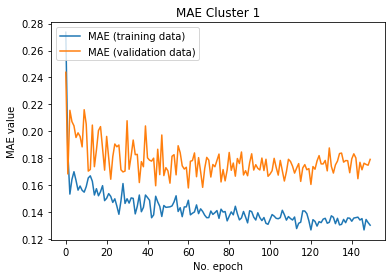

In [89]:
import matplotlib.pyplot as plt
plt.plot(hist.history['mae'], label='MAE (training data)')
plt.plot(hist.history['val_mae'], label='MAE (validation data)')

plt.title("MAE Cluster 1")
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

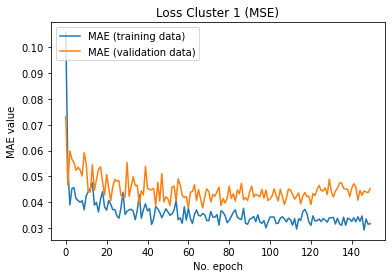

In [90]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='MAE (training data)')
plt.plot(hist.history['val_loss'], label='MAE (validation data)')

plt.title("Loss Cluster 1 (MSE)")
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [91]:
prediksi=model.predict(np.array(x_valid))
prediksi

array([[0.45561484],
       [0.5044383 ],
       [0.43263093],
       [0.33809075],
       [0.33388644],
       [0.24917227]], dtype=float32)

In [92]:
prediksi=prediksi.flatten()

In [93]:
hasil=np.concatenate((series,prediksi))

In [94]:
hasil

array([0.29515789, 0.23550877, 0.83789474, 0.28870175, 0.57277193,
       0.25614035, 0.47157895, 0.31522807, 0.47691228, 0.7762807 ,
       0.43214035, 0.02526316, 0.47157895, 0.49838596, 0.33431579,
       0.41038596, 0.49122807, 0.47045614, 0.49908772, 0.15859649,
       0.4405614 , 0.37178947, 0.08505263, 0.07578947, 0.48589474,
       0.68238596, 0.48196491, 0.46470175, 0.72785965, 0.25263158,
       0.53768421, 0.50315789, 0.54961404, 0.47635088, 0.69249123,
       0.40435088, 0.73249123, 0.50610526, 0.92547368, 0.21838596,
       0.05108772, 0.        , 0.2642807 , 0.25010526, 0.48308772,
       0.53431579, 0.4325614 , 0.41824561, 0.56561404, 0.54091228,
       0.84659649, 0.75621053, 0.48280702, 1.        , 0.45561484,
       0.50443828, 0.43263093, 0.33809075, 0.33388644, 0.24917227])

In [95]:
asli = np.concatenate((series,series_t))

In [96]:
hasil = hasil * (max-min) + min
asli = asli * (max-min) + min

[]

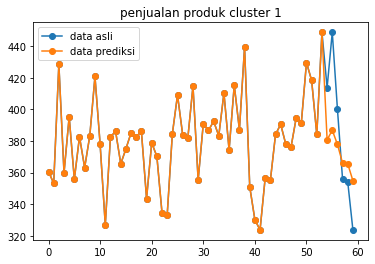

In [97]:
plt.plot(asli,marker = 'o',label='data asli')
plt.plot(hasil,marker = 'o',label='data prediksi')
plt.title('penjualan produk cluster 1')
plt.legend()
plt.plot()

In [98]:
model.save('cluster1_newdata.h5')

# Satu Produk

In [99]:
new_c1 = c1.sample()
new_c1

,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
18091,0,300,0,314,298,0,275,240,301,747,...,500,100,0,0,0,0,0,0,0,24


In [100]:
c1_t.set_index(col,inplace=True)
new_c1_t = c1_t.loc[new_c1.index]
new_c1_t

,bulan 1,bulan 2,bulan 3,bulan 4,bulan 5,bulan 6
18091,0,0,0,450,0,0


In [101]:
series=new_c1.values
min = np.min(series)
max = np.max(series)
series = series - min
series = series / (max-min)
time = np.array(time)

series_t=new_c1_t.values
min_t = np.min(series_t)
max_t = np.max(series_t)
series_t = series_t - min_t
series_t = series_t / (max_t-min_t)
time_t = np.array(time_t)

In [102]:
series = series.reshape(-1,)
series_t= np.array(series_t).reshape(-1,)

In [103]:
prediksi=model.predict(np.array(series_t))
prediksi

array([[0.24917227],
       [0.24917227],
       [0.24917227],
       [0.5044383 ],
       [0.24917227],
       [0.24917227]], dtype=float32)

In [104]:
prediksi=prediksi.flatten()

In [105]:
series = series*(max-min) + min
prediksi = prediksi*(max_t-min_t)+ min_t
series_t = series_t*(max_t-min_t) + min_t  
hasil=np.concatenate((series,prediksi))
asli = np.concatenate((series,series_t))

[]

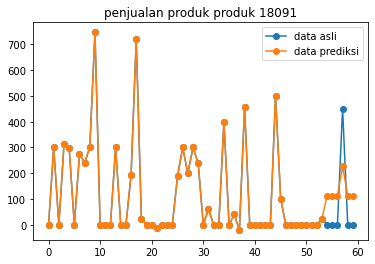

In [106]:
plt.plot(asli,marker = 'o',label='data asli')
plt.plot(hasil,marker = 'o',label='data prediksi')
plt.title('penjualan produk produk '+str(new_c1.index[0]))
plt.legend()
plt.plot()